In [4]:
import pandas as pd

training_dataset = pd.read_csv("./dataset/cleaned_dataset.csv")
training_dataset.drop(columns=['Cluster_DBSCAN'],inplace=True)
training_dataset.head()

,X_LOC,Y_LOC,Z_LOC,NPHI,DTC,SP,RHOB,GR,CALI,Lithology_code
0,455221.34375,6533321.5,-2883.996094,0.148734,68.589714,79.002701,2.346344,61.986121,7.918733,30000.0
1,455221.34375,6533321.5,-2883.843994,0.139775,68.007210,78.982742,2.350433,61.986166,7.893227,30000.0
2,455221.34375,6533321.5,-2883.691895,0.136017,68.325829,78.962296,2.364630,61.986210,7.876397,30000.0
3,455221.34375,6533321.5,-2883.540039,0.136147,69.102173,78.941872,2.388633,61.986253,7.887510,30000.0
4,455221.34375,6533321.5,-2883.387939,0.135847,69.374542,78.921913,2.411212,61.986298,7.914729,30000.0


In [8]:
from sklearn.cluster import KMeans
from sklearn.utils import shuffle
import pandas as pd

# Assume dataset_df_updated is your dataframe with 'Lithology_code' and feature columns

# Define the list of majority classes to undersample
majority_classes = [65000, 65030, 30000, 70000]  # Ganti dengan kode kelas mayoritas yang sesuai

# Get class frequencies to understand the initial distribution
class_counts = training_dataset['Lithology_code'].value_counts()

# Display initial distribution
print("Jumlah sampel sebelum undersampling:")
for cls in class_counts.index:
    print(f"Kelas {cls}: {class_counts[cls]} sampel")

# Identify minority classes (all classes not in majority_classes)
minority_classes = [cls for cls in class_counts.index if cls not in majority_classes]

target_size = 10000

# Features used for clustering
features_for_clustering = training_dataset.columns.to_list()

# List to hold the processed dataframes
df_list = []

# Process each class group
for cls, group in training_dataset.groupby('Lithology_code'):
    if cls in majority_classes and len(group) > target_size:
        # Perform clustering-based undersampling for majority classes exceeding target_size
        n_clusters = target_size
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        group['Cluster'] = kmeans.fit_predict(group[features_for_clustering])
        # Select one sample per cluster to maintain variation
        group_undersampled = group.groupby('Cluster').apply(
            lambda x: x.sample(1, random_state=42)
        ).reset_index(drop=True)
        df_list.append(group_undersampled.drop(columns=['Cluster']))
    else:
        # Keep all samples for minority classes or majority classes with size <= target_size
        df_list.append(group)

# Combine all processed dataframes
df_balanced = pd.concat(df_list, ignore_index=True)
df_balanced = shuffle(df_balanced, random_state=42).reset_index(drop=True)

# Display the class distribution after undersampling
print("\nDistribusi kelas setelah undersampling:")
print(df_balanced['Lithology_code'].value_counts())

Jumlah sampel sebelum undersampling:
Kelas 65000.0: 144966 sampel
Kelas 30000.0: 43855 sampel
Kelas 65030.0: 19920 sampel
Kelas 70000.0: 16767 sampel
Kelas 80000.0: 8245 sampel
Kelas 70032.0: 5343 sampel
Kelas 88000.0: 3919 sampel
Kelas 99000.0: 3824 sampel
Kelas 74000.0: 1109 sampel
Kelas 90000.0: 1031 sampel
Kelas 86000.0: 920 sampel
Kelas 93000.0: 141 sampel

Distribusi kelas setelah undersampling:
Lithology_code
65030.0    10000
30000.0    10000
70000.0    10000
65000.0    10000
80000.0     8245
70032.0     5343
88000.0     3919
99000.0     3824
74000.0     1109
90000.0     1031
86000.0      920
93000.0      141
Name: count, dtype: int64


In [14]:
df_balanced = pd.read_csv("./dataset/undersampling_dataset.csv")
df_balanced.drop(columns='RHOB', inplace=True)

,Description,Value
0,Session id,42
1,Target,Lithology_code
2,Target type,Multiclass
3,Target mapping,"30000.0: 0, 65000.0: 1, 65030.0: 2, 70000.0: 3, 70032.0: 4, 74000.0: 5, 80000.0: 6, 86000.0: 7, 88000.0: 8, 90000.0: 9, 93000.0: 10, 99000.0: 11"
4,Original data shape,"(51625, 9)"
5,Transformed data shape,"(51625, 9)"
6,Transformed train set shape,"(36137, 9)"
7,Transformed test set shape,"(15488, 9)"
8,Numeric features,8
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9450,0.9966,0.9450,0.9451,0.9448,0.9370,0.9371,0.3100
rf,Random Forest Classifier,0.9425,0.9963,0.9425,0.9426,0.9424,0.9341,0.9342,0.9270
knn,K Neighbors Classifier,0.9030,0.9812,0.9030,0.9035,0.9026,0.8889,0.8890,0.3590
dt,Decision Tree Classifier,0.8996,0.9415,0.8996,0.8997,0.8995,0.8849,0.8850,0.0780
lightgbm,Light Gradient Boosting Machine,0.8844,0.9627,0.8844,0.8846,0.8834,0.8682,0.8684,1.6490
gbc,Gradient Boosting Classifier,0.8716,0.0000,0.8716,0.8716,0.8712,0.8529,0.8530,17.9030
qda,Quadratic Discriminant Analysis,0.6608,0.0000,0.6608,0.6672,0.6584,0.6144,0.6158,0.0220
lr,Logistic Regression,0.5750,0.0000,0.5750,0.5707,0.5675,0.5106,0.5117,0.8430
lda,Linear Discriminant Analysis,0.5379,0.0000,0.5379,0.5332,0.5278,0.4687,0.4704,0.0220
nb,Naive Bayes,0.5340,0.8627,0.5340,0.5364,0.5180,0.4693,0.4734,0.0200


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

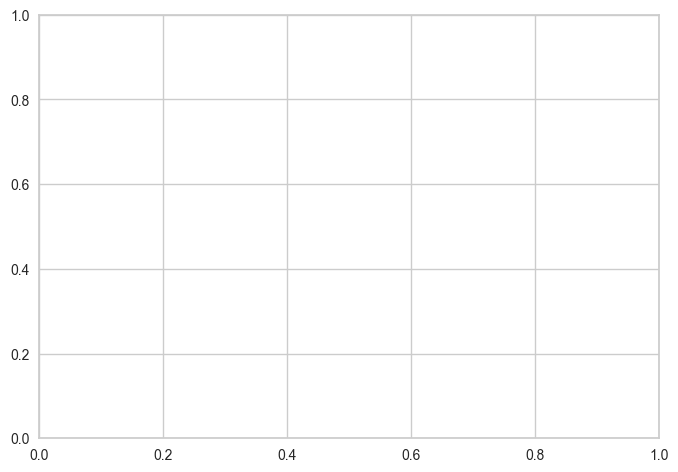

In [ ]:
from pycaret.classification import *
import pandas as pd
from sklearn.model_selection import train_test_split

# Load dataset (ganti dengan dataset yang sesuai)
data = df_balanced.copy()

# Pisahkan fitur dan target
target_column = "Lithology_code"  # Ganti dengan nama kolom target

# Split dataset into train and test
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Setup PyCaret
clf = setup(train_data, target=target_column, normalize=True, session_id=42)

# Compare models and find the best one
best_model = compare_models()

# Evaluate best model on training data
evaluate_model(best_model)

In [18]:
from sklearn.metrics import classification_report

# Evaluate best model on test data
test_predictions = predict_model(best_model, data=test_data)
print("Evaluation on test data:")
# print(test_predictions)

# Measure prediction quality
y_true = test_data[target_column]
y_pred = test_predictions['Lithology_code']
print("Classification Report:")
print(classification_report(y_true, y_pred))

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.9464,0.9965,0.9464,0.9464,0.9461,0.9386,0.9387


Evaluation on test data:
Classification Report:
              precision    recall  f1-score   support

     30000.0       1.00      1.00      1.00      2021
     65000.0       1.00      1.00      1.00      2040
     65030.0       1.00      1.00      1.00      1990
     70000.0       1.00      1.00      1.00      1953
     70032.0       1.00      1.00      1.00      1085
     74000.0       1.00      1.00      1.00       215
     80000.0       1.00      1.00      1.00      1625
     86000.0       1.00      1.00      1.00       181
     88000.0       1.00      1.00      1.00       802
     90000.0       1.00      1.00      1.00       218
     93000.0       1.00      1.00      1.00        28
     99000.0       1.00      1.00      1.00       749

    accuracy                           1.00     12907
   macro avg       1.00      1.00      1.00     12907
weighted avg       1.00      1.00      1.00     12907



In [19]:
y_pred.value_counts()

Lithology_code
65000.0    2040
30000.0    2021
65030.0    1990
70000.0    1953
80000.0    1625
70032.0    1085
88000.0     802
99000.0     749
90000.0     218
74000.0     215
86000.0     181
93000.0      28
Name: count, dtype: int64